In [106]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import shutil
import random
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

In [2]:
batch_size = 64
img_height = 224
img_width = 224

dataset1_path_train='/storage/Crack_detection/Dataset1_subset_train'
dataset1_path_test='/storage/Crack_detection/Dataset1_subset_test'

train_datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25)

train_ds=train_datagen.flow_from_directory(
    dataset1_path_train,  
    class_mode='binary',
    subset="training", 
    seed=11, 
    target_size=(img_height, img_width), 
    batch_size=batch_size)

val_datagen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25)

val_ds=val_datagen.flow_from_directory(
    dataset1_path_train,  
    class_mode='binary',
    subset="validation", 
    seed=11, 
    target_size=(img_height, img_width), 
    batch_size=batch_size)

test_datagen=ImageDataGenerator(rescale=1./255)

test_ds=test_datagen.flow_from_directory(
    dataset1_path_test, 
    class_mode='binary',
    seed=11, 
    target_size=(img_height, img_width), 
    batch_size=batch_size,
    shuffle=False)

Found 1200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [7]:
# load VGG16 and change last dense layer
vgg16_model=keras.applications.vgg16.VGG16(include_top=True, input_shape=(img_height, img_width, 3))
model=tf.keras.models.Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
for layer in model.layers:
    layer.trainable=False # freeze the layers - do not train them
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.build(input_shape=(img_height, img_width, 3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [8]:
# compile model and fit
model.compile(loss="binary_crossentropy",
              #optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

history=model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=10)

Epoch 1/10
19/19 [==============================] - 126s 7s/step - loss: 0.6400 - accuracy: 0.6453 - val_loss: 0.4223 - val_accuracy: 0.8575
Epoch 2/10
19/19 [==============================] - 126s 7s/step - loss: 0.3686 - accuracy: 0.8964 - val_loss: 0.3392 - val_accuracy: 0.8475
Epoch 3/10
19/19 [==============================] - 125s 7s/step - loss: 0.2820 - accuracy: 0.8967 - val_loss: 0.2912 - val_accuracy: 0.8650
Epoch 4/10
19/19 [==============================] - 126s 7s/step - loss: 0.2341 - accuracy: 0.9278 - val_loss: 0.2672 - val_accuracy: 0.8875
Epoch 5/10
19/19 [==============================] - 125s 7s/step - loss: 0.2208 - accuracy: 0.9240 - val_loss: 0.2201 - val_accuracy: 0.9225
Epoch 6/10
19/19 [==============================] - 126s 7s/step - loss: 0.1845 - accuracy: 0.9406 - val_loss: 0.1977 - val_accuracy: 0.9325
Epoch 7/10
19/19 [==============================] - 127s 7s/step - loss: 0.1649 - accuracy: 0.9454 - val_loss: 0.1929 - val_accuracy: 0.9250
Epoch 8/10
19

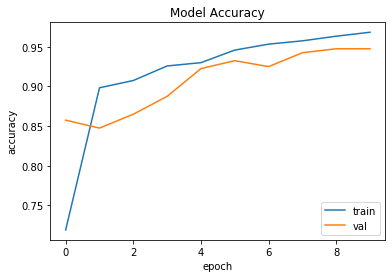

In [53]:
# plot train and val accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [9]:
# prediction and evaluation on test dataset
test_predict=model.predict(test_ds)
test_predict_classes=[1 if i>0.5 else 0 for i in test_predict]
test_loss, test_accuracy=model.evaluate(test_ds)
print('Test accuracy:', test_accuracy)

7/7 [==============================] - 32s 4s/step - loss: 0.1301 - accuracy: 0.9675
Test accuracy: 0.9674999713897705


[Text(33.0, 0.5, 'Prediction'), Text(0.5, 15.0, 'Class')]

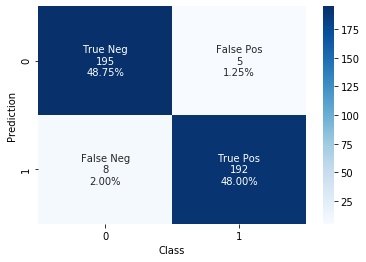

In [94]:
# plot confusion matrix
cm=confusion_matrix(test_ds.classes, test_predict_classes)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
ax.set(xlabel='Class', ylabel='Prediction')

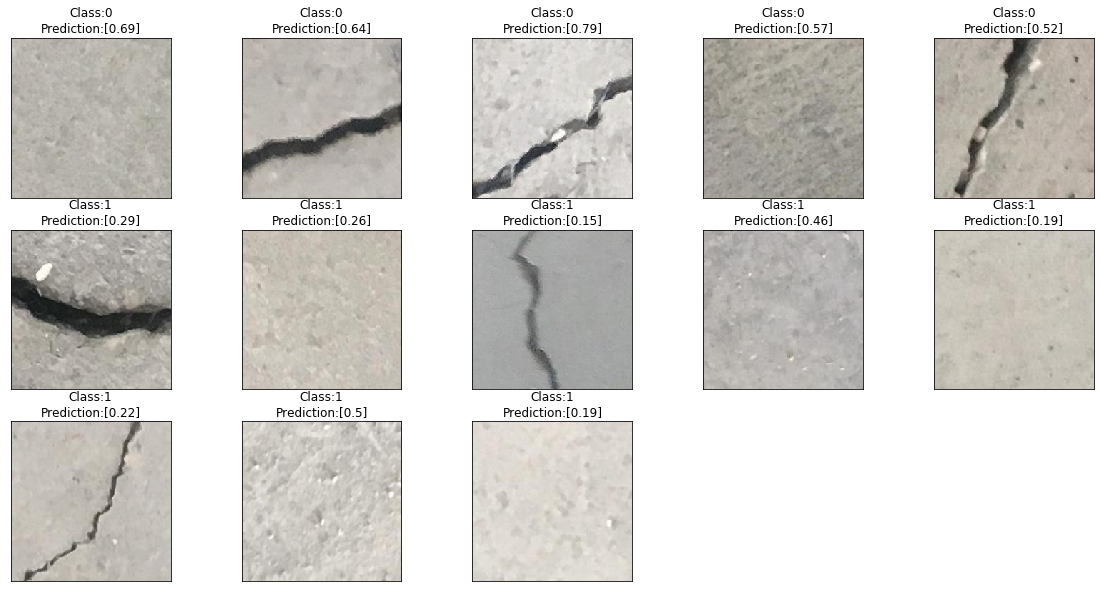

In [87]:
# find and plot wrong prediction
wrong_prediction_index=[]
for position, value in enumerate(test_predict_classes):
    if value != test_ds.classes[position]:
        wrong_prediction_index.append(position)

img_n_rows=len(wrong_prediction_index)//5+1        
image_idx=0
plt.figure(figsize=(20, 10))
for idx in wrong_prediction_index:
    image=train_ds[int(idx//batch_size)][0][int((idx/batch_size-idx//batch_size)*batch_size)]
    plt.subplot(3, 5, image_idx + 1)
    #plt.subplots(img_n_rows,5, image_idx)
    plt.imshow(image)
    plt.title('Class:' + str(test_ds.classes[idx]) +'\n'+'Prediction:' + str(np.round(test_predict[idx],2)))
    plt.xticks([])
    plt.yticks([])
    image_idx+=1    
plt.show()    

In [98]:
#save model
model.save('/Crack_detection/Crack_detection/vgg16_model_122620.h5')